In [3]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\hokut\デスクトップ\practice\Speech-AI-practice\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech"
print(text_to_sequence(text))


[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19]


In [5]:
processor = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

text = "Hello world Text to speech"
processed, lengths = processor(text)
print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 11, 31, 16, 35, 31, 11, 31,
         26, 11, 30, 27, 16, 16, 14, 19]])
tensor([26], dtype=torch.int32)


In [7]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h']


In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()

text = "Hello world Text to speech"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

100.0%


tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38, 11, 81, 40, 64, 79, 81, 11, 81, 20,
         11, 79, 77, 59, 37]])
tensor([23], dtype=torch.int32)


In [10]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH']


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to C:\Users\hokut/.cache\torch\hub\checkpoints\tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100.0%


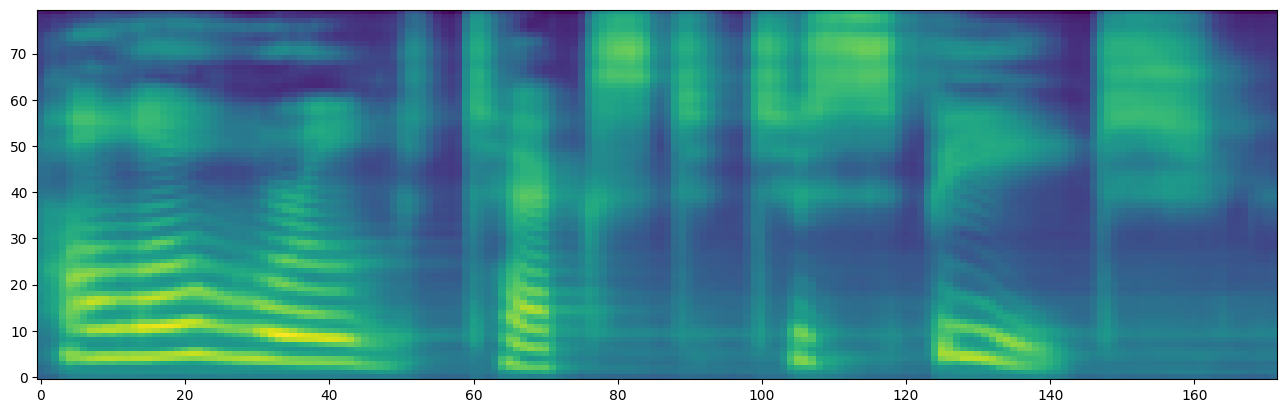

In [11]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world Text to speech"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 157])
torch.Size([80, 149])
torch.Size([80, 159])


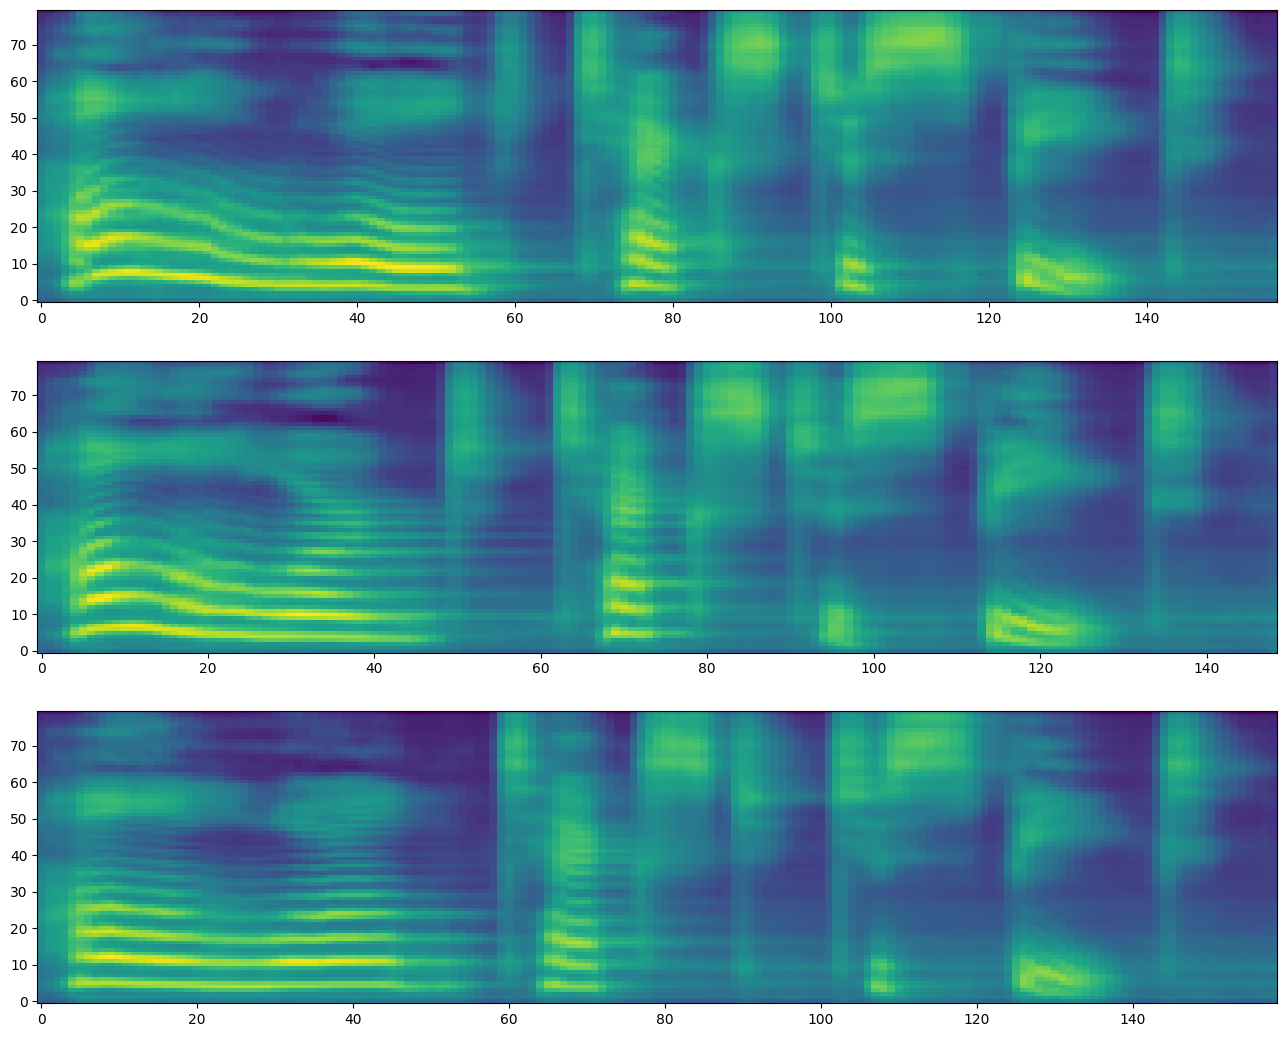

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3*3))
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)

    ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
plt.show()

### WaveRNN

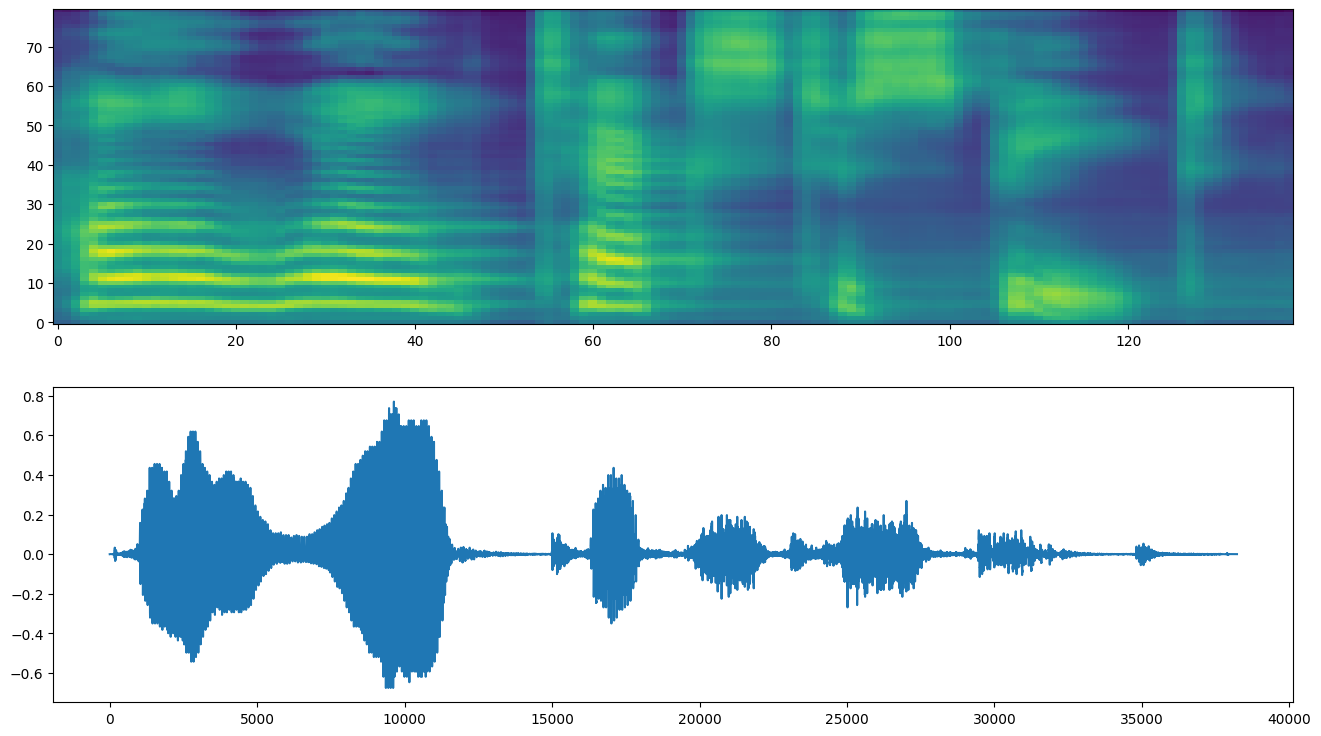

In [18]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world Text to speech"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

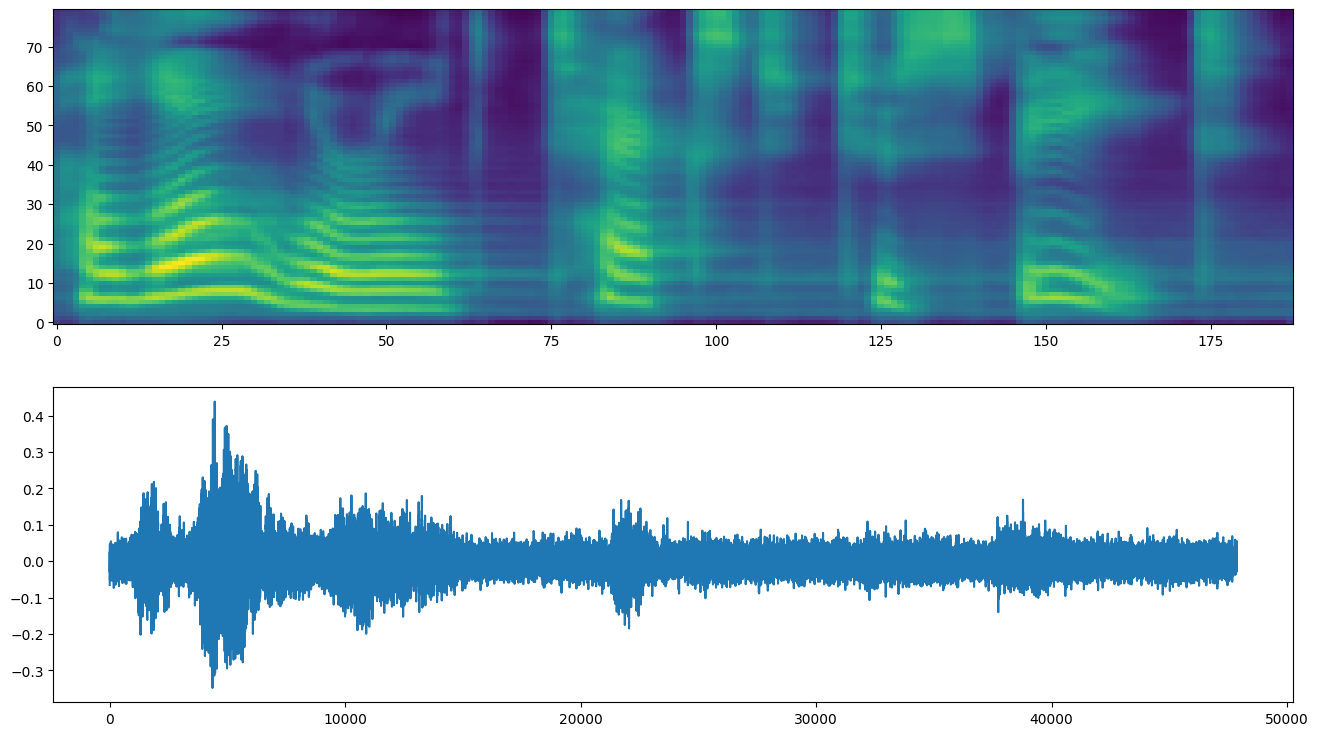

In [20]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax[0].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax[1].plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

### Waveglow

In [22]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)

checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",
    progress=False,
    map_location=device
)

c:\Users\hokut\デスクトップ\practice\Speech-AI-practice\.venv\lib\site-packages\torch\hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to C:\Users\hokut/.cache\torch\hub\torchhub.zip
C:\Users\hokut/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found

In [ ]:
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax[0].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax[1].plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)